# Lab Work 01 Supervised-Learning Logistic Regression - Binary

## Name: Thantham Khamyai
## Student ID: 122097

# Tasks Completed
+ Create LogisticRegression Class, and set default method as 'mini-batch'
+ Perform classification using given dataset creation
+ Plot learning curve through epochs
+ Create 'classification_report' containing 4 functions of each metric (accuracy, precision, recall, f1)

## Import Neccessary Packages

In [1]:
# Import Basic packages 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import sklaern packages and neccessary functions
from sklearn import linear_model
from sklearn.datasets import make_classification, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Implement Given Classification Dataset

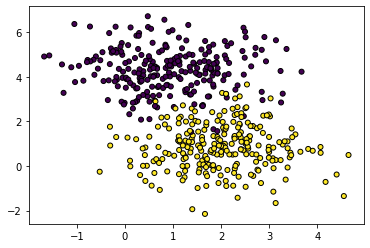

In [3]:
X, y = make_blobs(n_samples=500, centers=2, n_features=2, random_state=0) # Generate isotropic Gaussian blobs for clustering

plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k') # show scatter plot of them

## Feature Scaling

In [4]:
# feature scaling helps reaching convergence faster
scaler = StandardScaler() # create Scaler instance
X = scaler.fit_transform(X) # fit and transform X data for standradization

## Train Test Splitting

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # split training and testing data with 70/30 ratio randomly

## Add Intercept terms for each train and test data

In [6]:
# for avoiding repeatitive step of intercepts insertion, make function to do that
def add_intercept(X):
    ones_intercept = np.ones((X.shape[0], 1)) # create array of 1 following m dimension
    return np.concatenate((ones_intercept, X), axis=1) # concatenate one array to index 0 of X

In [7]:
intercept = add_intercept(X_train) # add intercept
intercept = add_intercept(X_test) # add intercept

## Show training data after feature scaling

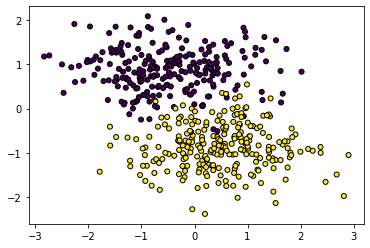

In [8]:
# show scatter plot to invualize data after scaling
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
            s=25, edgecolor='k')

## Task 1: Create LogisticRegression class

In [9]:
class LogisticRegression:
    
    def __init__(self, method='mini-batch', max_iterations=10000, early_stopping=False,
                       alpha=.0001, tol=.00001, mini_batch_size=100, previous_loss=10000,
                       record_history_every=100,  print_loss_every=1000):
        self.method = method
        self.max_iterations = max_iterations
        self.early_stopping = early_stopping
        self.alpha = alpha
        self.tol = tol
        self.mini_batch_size = mini_batch_size
        self.previous_loss = previous_loss # initial loss to investigate tol threshold for early stopping
        self.epoch_to_print = print_loss_every # print current loss for every ... interation
        self.epoch_to_record_history = record_history_every # record loss for every ... iteration
        self.training_history = [] # list to keep loss values from fitting

        
    def fit(self, X, y):
        # 1. initalize theta
        self.theta = self.init_theta(X)
        
        # init blank used idx list for check repeatitive idx of stochastiac method
        idx_used = [] # list to record used idx for stochastic method
        self.training_history = [] # lise to record loss values through epochs
        
        # 2. loop along predefined n iterations
        for i in range(self.max_iterations):

            # 2.1 condition to choose method
            if self.method=='batch':
                # pass all samples
                x_to_train = X # dump all x
                y_to_train = y # dump sll y

            elif self.method=='stochastic': # <= With Replacement
                # randomly select 1 sample
                select_idx = np.random.randint(X.shape[0])# random idx
                while select_idx in idx_used:
                    select_idx = np.random.randint(X.shape[0])# random idx
                    
                x_to_train = np.array([X[select_idx, :]]) # extract one X by idx 
                y_to_train = np.array([y[select_idx]]) # extract one y by idx
                
                idx_used.append(select_idx)
                
                if len(idx_used) == X.shape[0]:
                    idx_used = []

            elif self.method=='mini-batch':
                # randomly select portion of samples following predefined mini batch size
                select_start_idx = np.random.randint(X.shape[0] - self.mini_batch_size) # random starting idx
                x_to_train = X[select_start_idx:select_start_idx + self.mini_batch_size, :] # extract portion of X
                y_to_train = y[select_start_idx:select_start_idx + self.mini_batch_size] # extract portion of y

            else:
                print('''wrong method defined 'batch','stochastic','mini-batch' only''')
                return

            # 2.2 predict y hat by dot x_to_train with theta
            yhat = self.predict(x_to_train)

            # 2.3 calculate error by minus yhst with y_to_train
            error = yhat - y_to_train

            # 2.4 calculate current mse to detect early stopping
            current_loss = self.loss(yhat, y_to_train)

            # 2.5 if early stopping set as True & difference of current and previous loss is less than threshold
            if self.early_stopping & (np.abs(self.previous_loss - current_loss) < self.tol):
                self.stop_epoch = i # keep early stopping iteration in stop_epoch variable
                # print early stopped epoch and exit loop
                print(f'early_stopped at epoch: {i+1}')
                break

            # 2.6 if not early stop or set False, update previous loss
            self.previous_loss = current_loss

            # 2.7 calculate gradient of trainingdata
            grad = self.gradient(x_to_train, error)

            # 2.8 update theta
            self.theta = self.theta - self.alpha * grad
            
            # add history loss
            if i % self.epoch_to_record_history ==0: # if this iteration is every ... for recording loss
                self.training_history.append(current_loss) # save this loss
            
            # print current loss
            if i % self.epoch_to_print == 0: # if this iteration is every ... for printing loss
                print(f'loss at epoch {i}: {current_loss}') # print current iteration loss
        
        self.stop_epoch = i # if no early stopping -> keep last iteration number to stop_epoch
        print(f'fitting model completed by loss: {current_loss}')
    
    def show_history(self):
        
        if len(self.training_history) == 0: # if no loss in history list
            print('hitory is empty!, fit model before!')
        else: # else show learning curve
            plt.plot(np.arange(start = 1, stop = self.stop_epoch, step=self.epoch_to_record_history) , self.training_history, label = "Train Losses")
            plt.title("Losses thourgh learning curve")
            plt.xlabel("number of epoch")
            plt.ylabel("losses")
            plt.legend()
    
    # function to predict yhat   
    def predict(self, X):
        return self.sigmoid(X @ self.theta) # put h in sigmoid function

    # function to calculate loss
    def loss(self, yhat, y):
        return - np.sum(y * np.log(yhat) + (1 - y) * np.log(1 - yhat)) # losgistic loss function

    # function to calculate gradient
    def gradient(self, X, error):
        return X.T @ error

    # function to create initial theta
    def init_theta(self, X):
        return np.zeros((X.shape[1])) # fill all theta with 0
    
    # function to return sigmoid
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x)) # sigmoid function
    
    def round_pred(self, pred):
        return np.round(pred) # use for rounding predicted y for classification report check


## Task 2: Perform classification

### 2.1 Create model instance

In [60]:
# selective methods are 'batch', 'mini-batch', 'stochastic'

model = LogisticRegression(method='mini-batch', max_iterations=30000, early_stopping=True, 
                           alpha=.0001, tol=.00001, mini_batch_size=100, record_history_every=200,print_loss_every=500)

### 2.2 perform classification (implementing early stopping also)

In [61]:
model.fit(X_train, y_train) # ftting model

loss at epoch 0: 69.31471805599453
loss at epoch 500: 24.828918367526043
loss at epoch 1000: 18.557274714399345
loss at epoch 1500: 19.92890748212013
loss at epoch 2000: 17.740530287824306
loss at epoch 2500: 12.324009890058612
loss at epoch 3000: 14.404344054255949
loss at epoch 3500: 16.270666611905643
loss at epoch 4000: 11.388406461182468
loss at epoch 4500: 9.039067106660136
loss at epoch 5000: 11.675330662668532
loss at epoch 5500: 11.705713577023023
loss at epoch 6000: 13.512212974489573
loss at epoch 6500: 12.447726913521308
loss at epoch 7000: 7.261179267483871
loss at epoch 7500: 6.358078872374528
loss at epoch 8000: 11.678742433890672
loss at epoch 8500: 10.379284415844424
loss at epoch 9000: 10.482907469939008
loss at epoch 9500: 11.675917437635981
loss at epoch 10000: 7.154124705112608
loss at epoch 10500: 5.771609730498778
loss at epoch 11000: 11.205126480599361
loss at epoch 11500: 9.532198874458304
loss at epoch 12000: 7.108084048796765
loss at epoch 12500: 11.527787939

### 2.3 predicting y by x_test and show training loss

In [62]:
y_pred = model.predict(X_test)
loss = model.loss(y_pred, y_test)
print(f'Testing loss: {loss}')

Testing loss: 13.57591198544372


## Task 3: Plot Learning

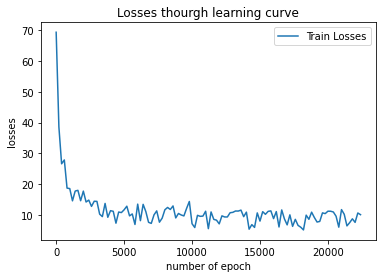

In [63]:
# just use show history functionfrom modelinstance
model.show_history()

## Task 4: Create classification_report class and evaluate model using created class

### 4.1 Create class of classification_report

In [67]:
class classification_report():
    
    def __init__(self, actual, predict):
        
        self.actual = actual
        self.predict = predict
        
        self.TP = ((self.actual == 1) & (self.predict == 1)).sum() # True Positive (correct prediction)
        self.TN = ((self.actual == 0) & (self.predict == 0)).sum() # True Negative (correct prediction)
        self.FN = ((self.actual == 1) & (self.predict == 0)).sum() # False Negative (Predict as No, but actually Yes)
        self.FP = ((self.actual == 0) & (self.predict == 1)).sum() # False Positive (Predict as Yes, but actually No)
        
    def accuracy(self):
        # Accuracy = (TP+TN)/(TP+TN+FN+FP)
        self.acc = 100 * (self.TP + self.TN)/ float( self.TP + self.TN + self.FN + self.FP)
        return self.acc
    
    def precision(self):
        # Precision = (TP)/(TP+FP)
        self.precision = 100* (self.TP)/ float(self.TP + self.FP)
        return self.precision
    
    def recall(self):
        # Recall = (TP)/(TP+FN)
        self.recall = (100* self.TP)/ float(self.TP + self.FN)
        return self.recall
        
    def f1(self):
        # F1 = 2 * (Precision * Recall) / (Precision + Recall)
        self.f1 = 2 * self.precision * self.recall / (self.precision + self.recall)
        return self.f1

### 4.2 Implement created classificaiton report class

In [68]:
report = classification_report(y_test, model.round_pred(y_pred)) #

print('Model Evaluation')
print(f'Evaluation - Accuracy : {report.accuracy()} %')
print(f'Evaluation - Precision : {report.precision()} %')
print(f'Evaluation - Recall : {report.recall()} %')
print(f'Evaluation - F1 : {report.f1()} %')

Model Evaluation
Evaluation - Accuracy : 96.66666666666667 %
Evaluation - Precision : 97.10144927536231 %
Evaluation - Recall : 95.71428571428571 %
Evaluation - F1 : 96.40287769784172 %


### ! Case of using classificaiton report from sklearn.metrics

In [69]:
from sklearn.metrics import classification_report

print('Scikit-learn Classification Report: \n{}'.format(classification_report(y_test, model.round_pred(y_pred))))

Scikit-learn Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        80
           1       0.97      0.96      0.96        70

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150

